In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller,acf,pacf

from statsmodels.tsa.statespace.tools import diff

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing

In [2]:
# Read the dataset file
data = pd.read_excel('salesdata.xls')
print(data.shape)
data.head()

(9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
data.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [4]:
data.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

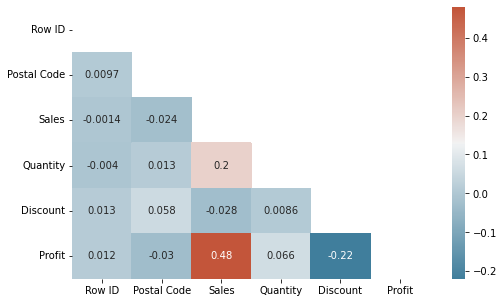

In [5]:
# Heatmap plot
corr = data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(8, 5))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap,annot = True)
plt.show()

In [6]:
def myOutliers(df,col):
    Q3 = np.quantile(df[col],0.75)
    Q1 = np.quantile(df[col],0.25)
    
    IQR = Q3 - Q1
    
    global mylist
    global my_outlier_df
    
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    
    print('the lower range of',col,'is',lower_range)
    print('the upper range of',col,'is',upper_range)
    
    mylist = [x for x in df[col] if ((x < lower_range) | (x > upper_range))]
    print('total outliers in',col,'are',len(mylist))
    
    
    my_outlier_df = df.loc[df[col].isin(mylist)]
    return my_outlier_df

In [7]:
numeric_columns = ['Sales','Quantity','Discount','Profit']

for i in numeric_columns:
    myOutliers(data,i)
    print('**************************************')

the lower range of Sales is -271.71000000000004
the upper range of Sales is 498.93
total outliers in Sales are 1167
**************************************
the lower range of Quantity is -2.5
the upper range of Quantity is 9.5
total outliers in Quantity are 170
**************************************
the lower range of Discount is -0.30000000000000004
the upper range of Discount is 0.5
total outliers in Discount are 856
**************************************
the lower range of Profit is -39.724124999999994
the upper range of Profit is 70.81687499999998
total outliers in Profit are 1881
**************************************


In [8]:
delta = data['Ship Date'] - data['Order Date']
data['Days to ship'] = delta.dt.days

In [9]:
data.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Days to ship'],
      dtype='object')

In [10]:
data.drop(['Row ID','Order ID','Customer ID','Customer Name','Country','Product Name','Product ID','Postal Code'],axis = 1).head(2)

,Order Date,Ship Date,Ship Mode,Segment,City,State,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Days to ship
0,2016-11-08,2016-11-11,Second Class,Consumer,Henderson,Kentucky,South,Furniture,Bookcases,261.96,2,0.0,41.9136,3
1,2016-11-08,2016-11-11,Second Class,Consumer,Henderson,Kentucky,South,Furniture,Chairs,731.94,3,0.0,219.5820,3


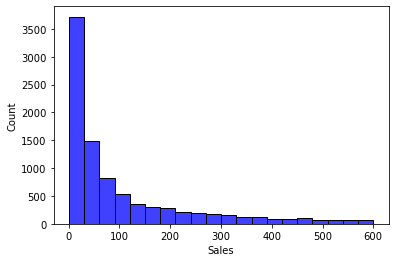

In [11]:
sns.histplot(data[data['Sales']<=600]['Sales'],bins=20,color='blue')
plt.show()

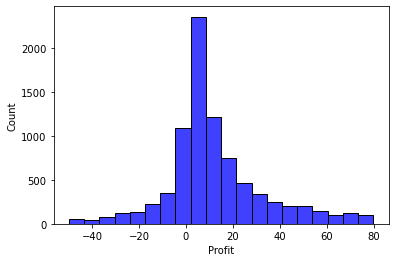

In [12]:
sns.histplot(data[data['Profit'].between(-50, 80)]['Profit'],bins=20,color='blue')
plt.show()

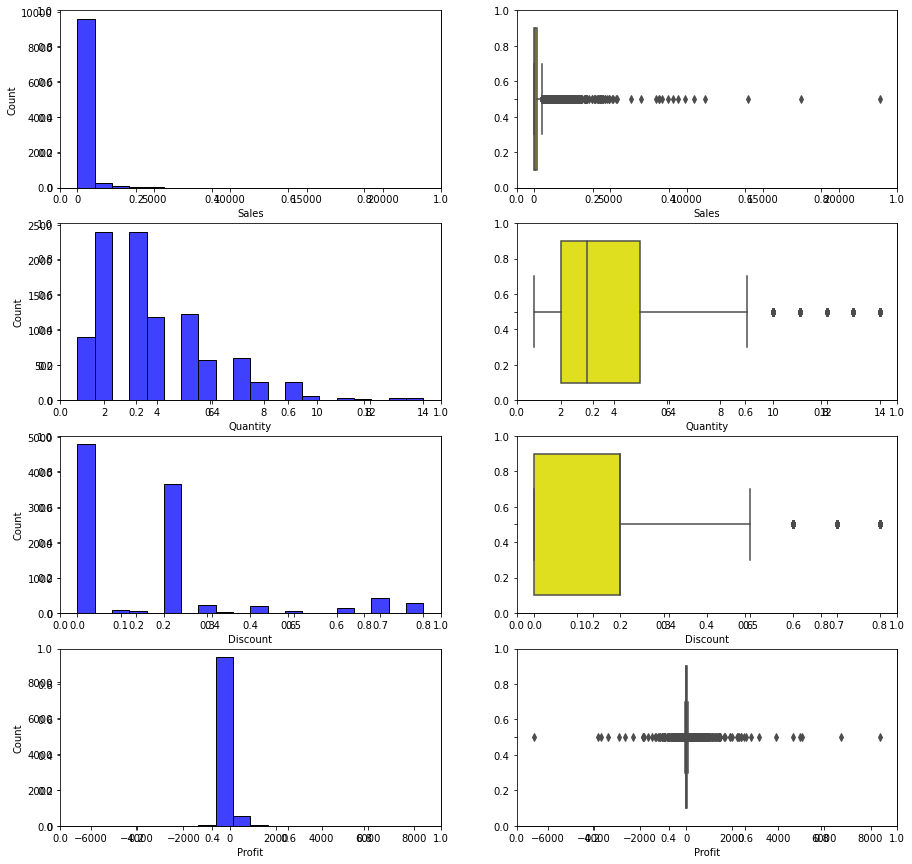

In [13]:
COLS = 2; POS = 1; ROWS = int(len(numeric_columns))
fig,ax = plt.subplots(ROWS,COLS,figsize=(15,15))
for i in numeric_columns:
    fig.add_subplot(ROWS,COLS,POS)  
    sns.histplot(data[i],bins=20,color='blue')
    POS+= 1  
    fig.add_subplot(ROWS,COLS,POS)  
    sns.boxplot(data[i],color='yellow')
    POS+= 1

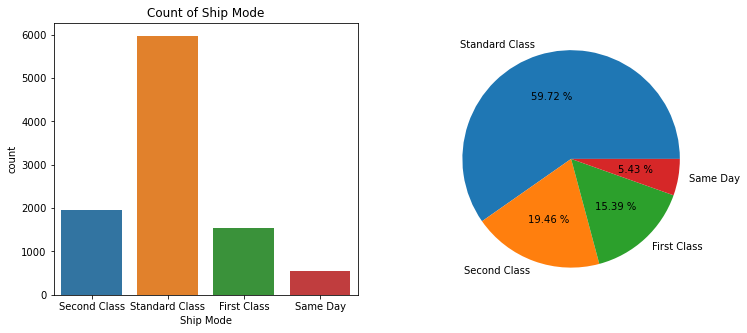

In [14]:
fig, ax = plt.subplots(1,2,figsize = (12,5))

ax[0].set_title('Count of Ship Mode')
percentage = data['Ship Mode'].value_counts()
labels = list(data['Ship Mode'].value_counts().index)

sns.countplot(x = data['Ship Mode'], ax = ax[0])
plt.pie(percentage,labels=labels,autopct = '%.2f %%')

plt.show()

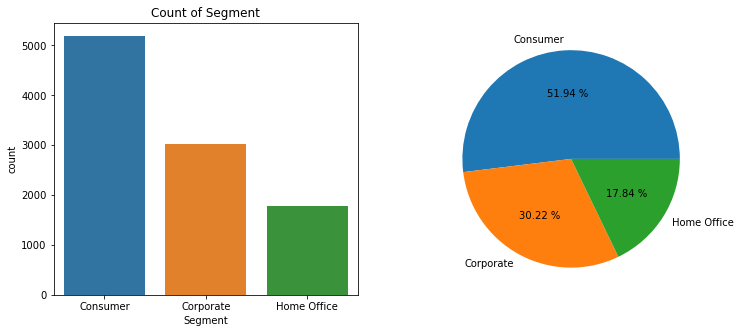

In [15]:
fig, ax = plt.subplots(1,2,figsize = (12,5))

ax[0].set_title('Count of Segment')
percentage = data['Segment'].value_counts()
labels = list(data['Segment'].value_counts().index)

sns.countplot(x = data['Segment'], ax = ax[0])
plt.pie(percentage,labels=labels,autopct = '%.2f %%')

plt.show()

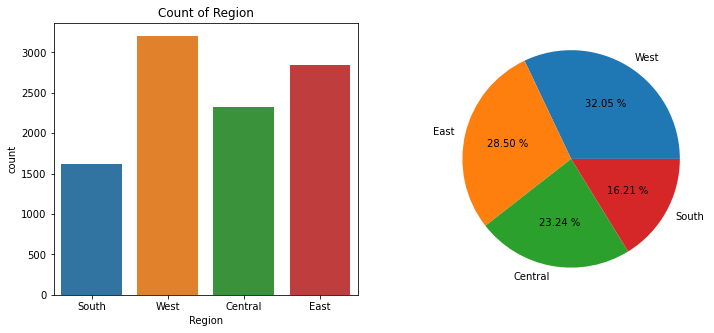

In [16]:
fig, ax = plt.subplots(1,2,figsize = (12,5))

ax[0].set_title('Count of Region')
percentage = data['Region'].value_counts()
labels = list(data['Region'].value_counts().index)

sns.countplot(x = data['Region'], ax = ax[0])
plt.pie(percentage,labels=labels,autopct = '%.2f %%')

plt.show()

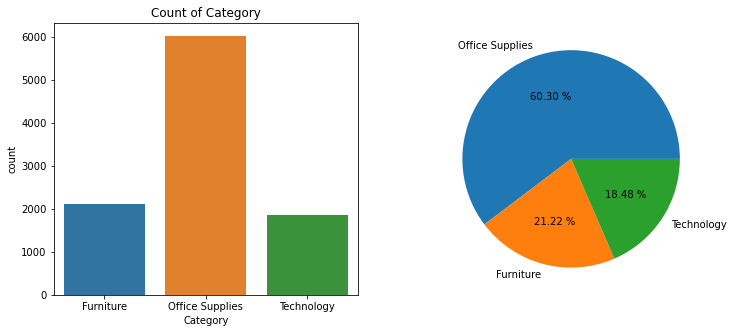

In [17]:
fig, ax = plt.subplots(1,2,figsize = (12,5))

ax[0].set_title('Count of Category')
percentage = data['Category'].value_counts()
labels = list(data['Category'].value_counts().index)

sns.countplot(x = data['Category'], ax = ax[0])
plt.pie(percentage,labels=labels,autopct = '%.2f %%')

plt.show()

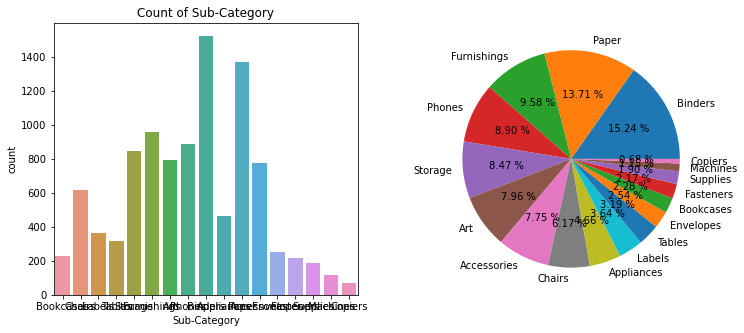

In [18]:
fig, ax = plt.subplots(1,2,figsize = (12,5))

ax[0].set_title('Count of Sub-Category')
percentage = data['Sub-Category'].value_counts()
labels = list(data['Sub-Category'].value_counts().index)

sns.countplot(x = data['Sub-Category'], ax = ax[0])
plt.pie(percentage,labels=labels,autopct = '%.2f %%')

plt.show()

### Bi variate analysis

In [19]:
def annotate(bars,ax=ax):
    for bar in bars:
        height = bar.get_height()
        height = round(height,2)
        label_x_pos = bar.get_x() + bar.get_width() / 2
        ax.text(label_x_pos, height, s=f'{height}', ha='center',
        va='bottom')

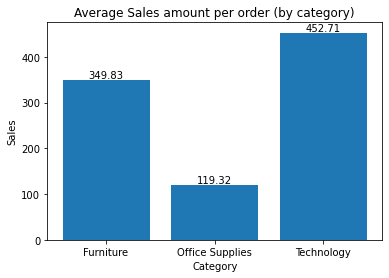

In [20]:
df = data.groupby('Category')['Sales'].mean()

fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(df.index, df.values)
annotate(bars,ax)
    
plt.title('Average Sales amount per order (by category)')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.show()

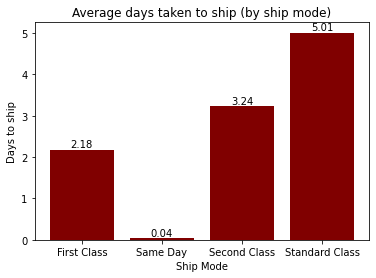

In [21]:
df = data.groupby('Ship Mode')['Days to ship'].mean()
plt.bar(df.index, df.values,color = 'g')

bars = plt.bar(df.index, df.values,color = 'maroon')
annotate(bars,plt)
    
plt.title('Average days taken to ship (by ship mode)')
plt.xlabel('Ship Mode')
plt.ylabel('Days to ship')
plt.show()

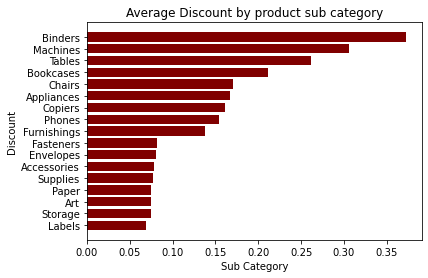

In [22]:
df = data.groupby('Sub-Category')['Discount'].mean().sort_values()

plt.barh(df.index, df.values,color = 'maroon')
    
plt.title('Average Discount by product sub category')
plt.xlabel('Sub Category')
plt.ylabel('Discount')
plt.show()

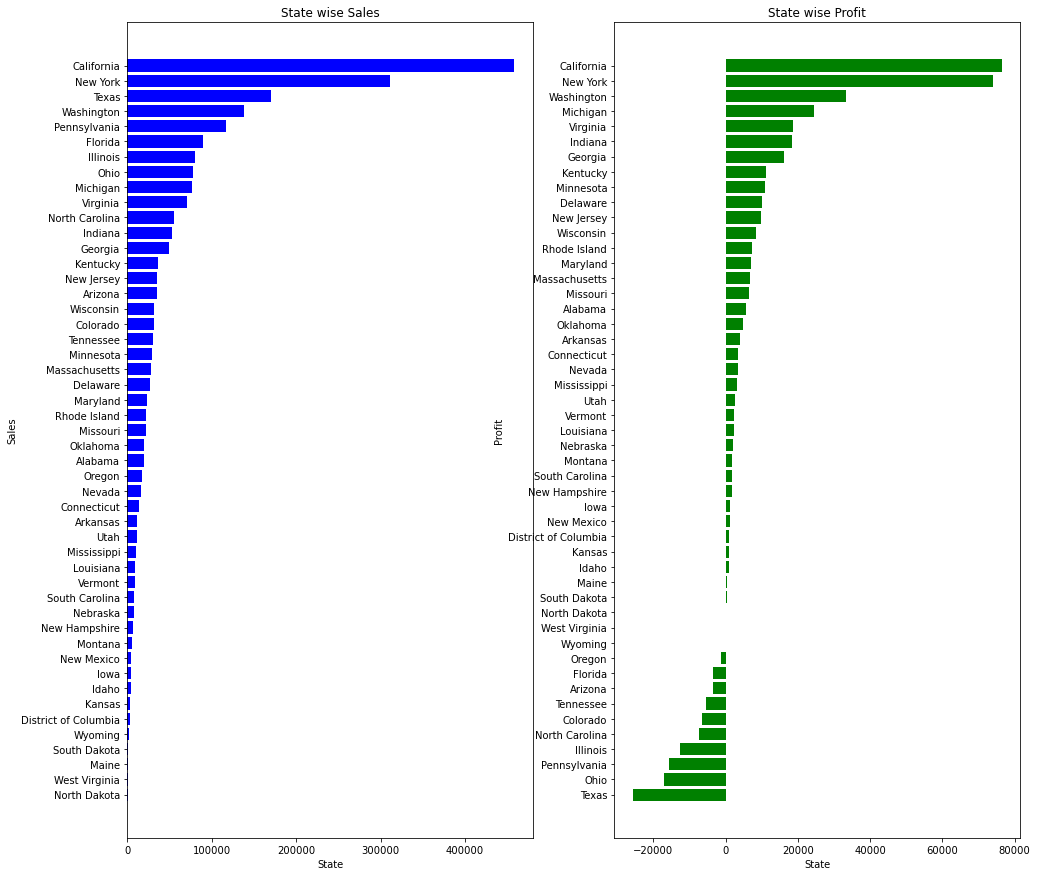

In [23]:
df = data.groupby('State')['Sales'].sum().sort_values()

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(16,15))
ax1.barh(df.index, df.values,color = 'b')
    
ax1.set_title('State wise Sales')
ax1.set_xlabel('State')
ax1.set_ylabel('Sales')

df = data.groupby('State')['Profit'].sum().sort_values()

ax2.barh(df.index, df.values,color = 'g')

    
ax2.set_title('State wise Profit')
ax2.set_xlabel('State')
ax2.set_ylabel('Profit')
plt.show()

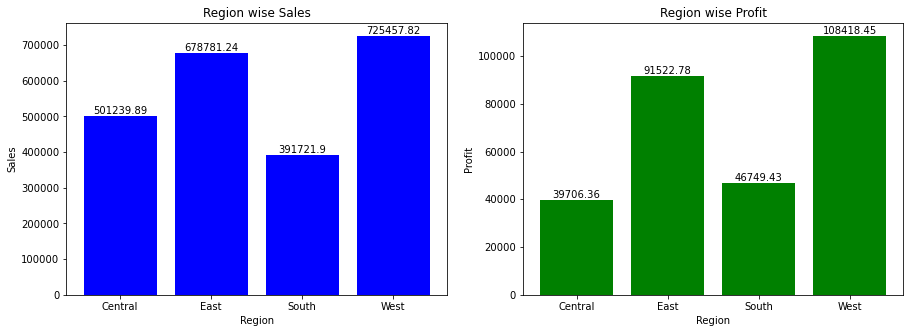

In [24]:
df = data.groupby('Region')['Sales'].sum()

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(15,5))
bars = ax1.bar(df.index, df.values,color = 'b')
annotate(bars,ax1)
    
ax1.set_title('Region wise Sales')
ax1.set_xlabel('Region')
ax1.set_ylabel('Sales')

df = data.groupby('Region')['Profit'].sum()

bars = ax2.bar(df.index, df.values,color = 'g')
annotate(bars,ax2)
    
ax2.set_title('Region wise Profit')
ax2.set_xlabel('Region')
ax2.set_ylabel('Profit')
plt.show()

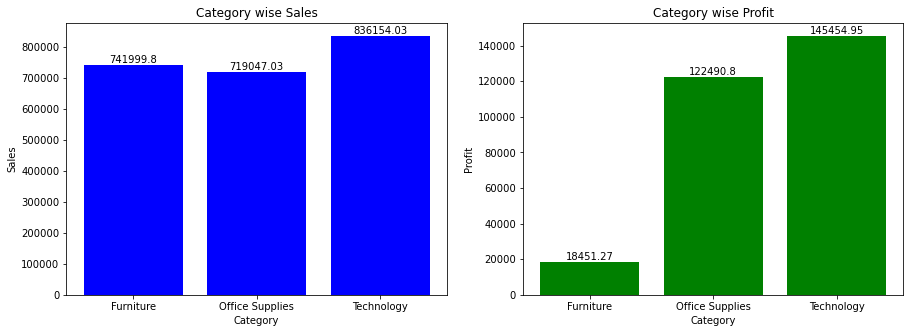

In [25]:
df = data.groupby('Category')['Sales'].sum()

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(15,5))
bars = ax1.bar(df.index, df.values,color = 'b')
annotate(bars,ax1)
    
ax1.set_title('Category wise Sales')
ax1.set_xlabel('Category')
ax1.set_ylabel('Sales')

df = data.groupby('Category')['Profit'].sum()

bars = ax2.bar(df.index, df.values,color = 'g')
annotate(bars,ax2)
    
ax2.set_title('Category wise Profit')
ax2.set_xlabel('Category')
ax2.set_ylabel('Profit')
plt.show()

Text(0, 0.5, 'Quantity')

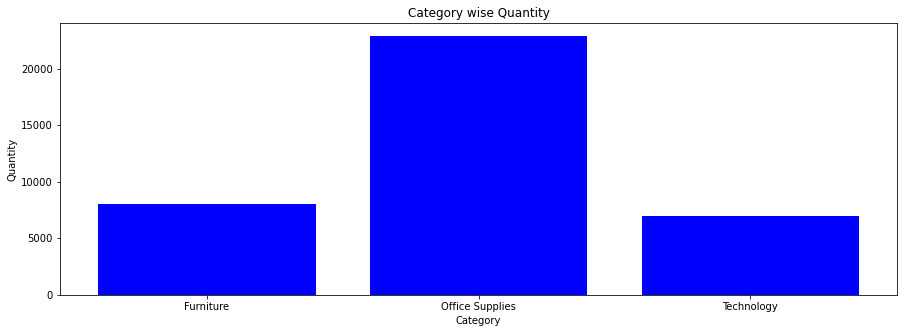

In [26]:
df = data.groupby('Category')['Quantity'].sum()

fig, ax = plt.subplots(1,1,figsize=(15,5))
bars = ax.bar(df.index, df.values,color = 'b')
annotate(bars,ax1)

ax.set_title('Category wise Quantity')
ax.set_xlabel('Category')
ax.set_ylabel('Quantity')

Text(0, 0.5, 'Discount')

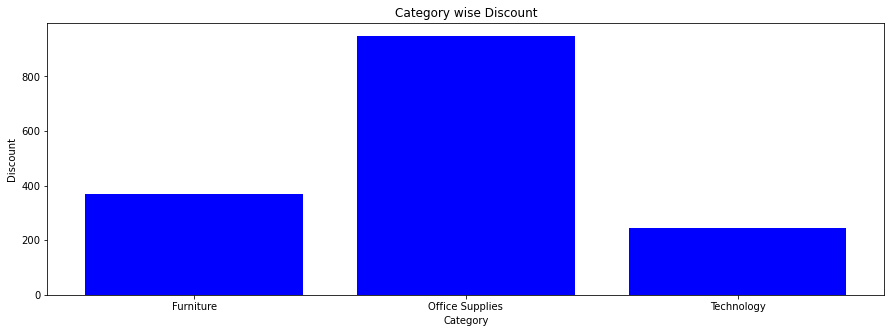

In [26]:
df = data.groupby('Category')['Discount'].sum()

fig, ax = plt.subplots(1,1,figsize=(15,5))
bars = ax.bar(df.index, df.values,color = 'b')
annotate(bars,ax1)
  
ax.set_title('Category wise Discount')
ax.set_xlabel('Category')
ax.set_ylabel('Discount')

In [27]:
data1 = data.set_index('Order Date')
data1 = data1.sort_index()

In [28]:
sales = data1[data1['Category'] == 'Furniture']['Sales'].resample('MS').mean()

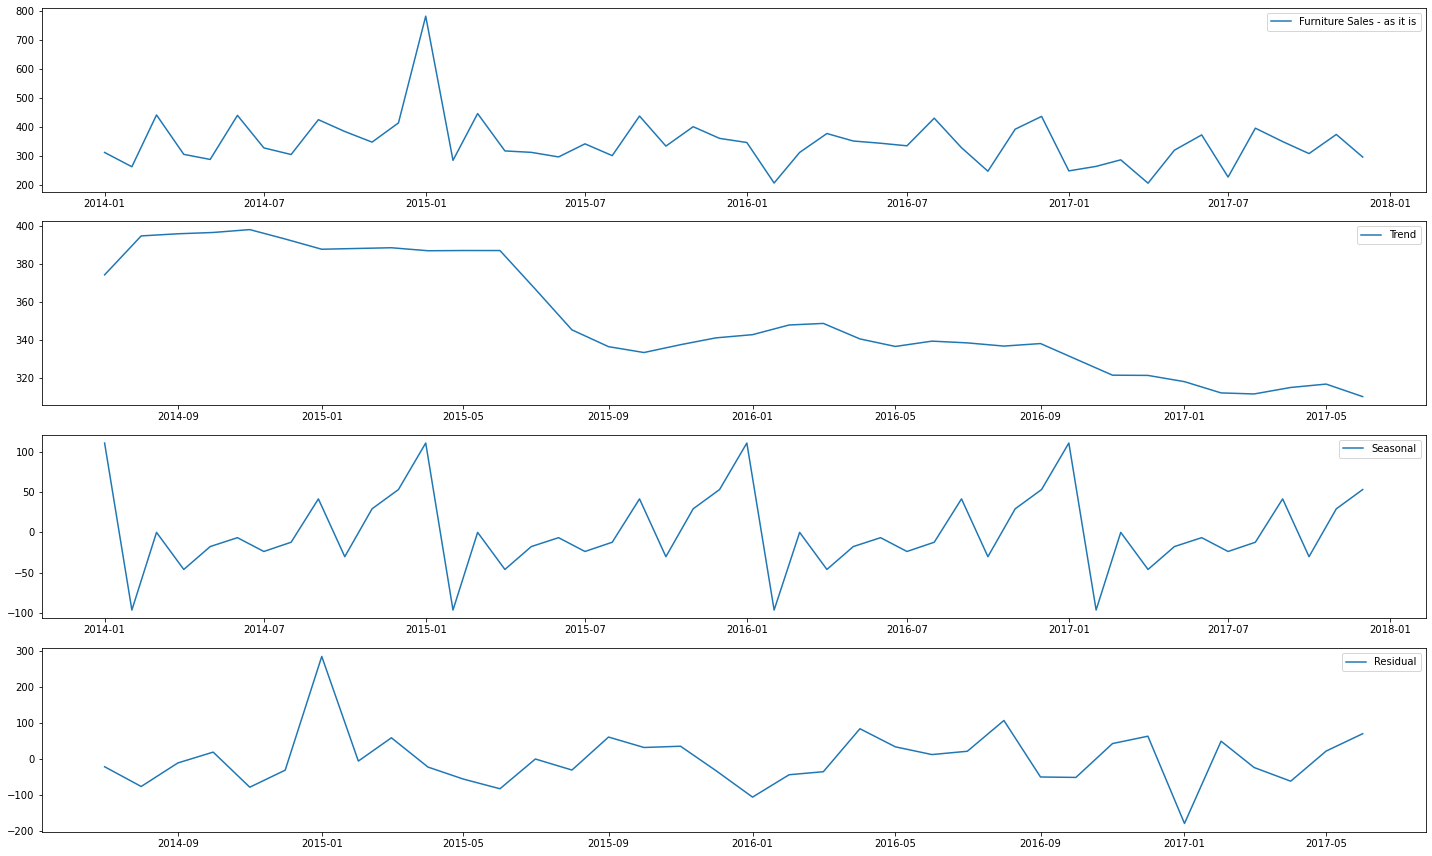

In [29]:
decomposition=seasonal_decompose(sales)
d_trend=decomposition.trend
d_seasonal=decomposition.seasonal
d_residual=decomposition.resid

# plotting all the 4 graphs
fig,ax = plt.subplots(4,1,figsize=(20,12))

plt.subplot(411)
plt.plot(sales,label='Furniture Sales - as it is')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(d_trend,label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(d_seasonal,label='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(d_residual,label='Residual')
plt.legend(loc='best')

plt.tight_layout()

### Moving average

In [29]:
lags = 2
moving_avg = sales.rolling(window=lags).mean()

In [30]:
df_f = pd.DataFrame({'actual':sales, 'ma':moving_avg})
print(df_f)

                actual          ma
Order Date                        
2014-01-01  312.126250         NaN
2014-02-01  262.808286  287.467268
2014-03-01  441.635030  352.221658
2014-04-01  305.570654  373.602842
2014-05-01  288.032792  296.801723
2014-06-01  440.204187  364.118489
2014-07-01  327.910636  384.057412
2014-08-01  305.014437  316.462537
2014-09-01  425.294300  365.154369
2014-10-01  384.507719  404.901009
2014-11-01  347.820527  366.164123
2014-12-01  414.134682  380.977605
2015-01-01  782.662773  598.398728
2015-02-01  284.943091  533.802932
2015-03-01  446.420821  365.681956
2015-04-01  317.445409  381.933115
2015-05-01  312.498350  314.971880
2015-06-01  296.699192  304.598771
2015-07-01  341.860500  319.279846
2015-08-01  301.206006  321.533253
2015-09-01  437.883717  369.544861
2015-10-01  334.072875  385.978296
2015-11-01  401.049773  367.561324
2015-12-01  360.715925  380.882849
2016-01-01  346.488318  353.602122
2016-02-01  206.607947  276.548133
2016-03-01  312.2217

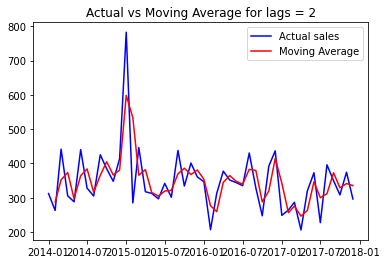

In [31]:
# plot the actual and moving average for comparison
plt.plot(df_f.actual, color='blue',label = 'Actual sales')
plt.plot(df_f.ma, color='red', label = 'Moving Average')
plt.title('Actual vs Moving Average for lags = ' + str(lags))
plt.legend()
plt.show()

Since the data contains both Trend and Seasonality, We shall use Triple Exponential smoothing.

### Triple Exponent Smoothing

Text(0.5, 1.0, 'Triple Exponent Smoothing')

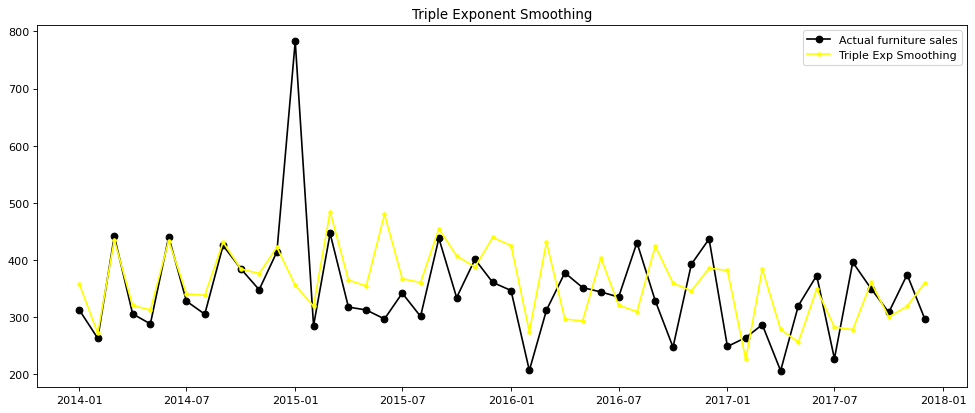

In [32]:
# build model
model = ExponentialSmoothing(sales,trend='add',seasonal='add',seasonal_periods=12).fit()

# plot the actual and triple smoothing values
plt.figure(figsize=(15, 6), dpi=80)
plt.plot(sales, marker='o',color='black',label='Actual furniture sales')
plt.plot(model.fittedvalues,marker='.',color='yellow',label='Triple Exp Smoothing')
plt.legend()
plt.title('Triple Exponent Smoothing')

In [33]:
model.forecast(12)

2018-01-01    319.462968
2018-02-01    199.407264
2018-03-01    335.079347
2018-04-01    242.098079
2018-05-01    246.325424
2018-06-01    328.575920
2018-07-01    249.228343
2018-08-01    274.611576
2018-09-01    328.789184
2018-10-01    271.890763
2018-11-01    296.478548
2018-12-01    324.398858
Freq: MS, dtype: float64

Text(0.5, 1.0, 'Triple Exponent Smoothing with forecast')

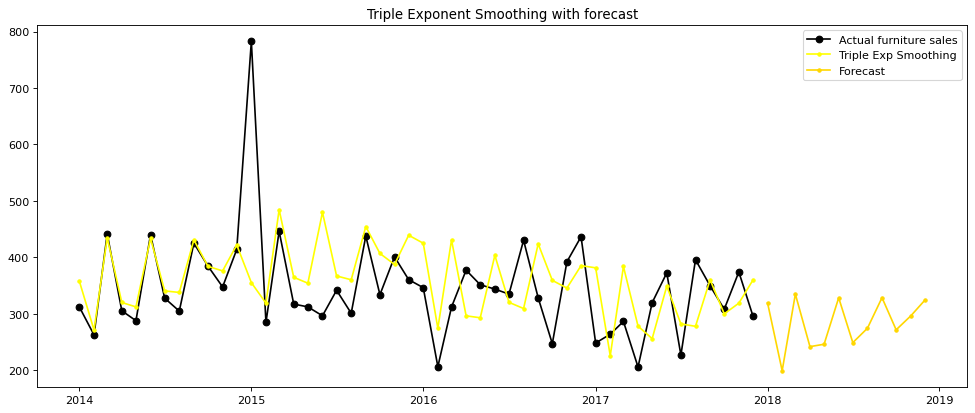

In [34]:
plt.figure(figsize=(15, 6), dpi=80)
plt.plot(sales, marker='o',color='black',label='Actual furniture sales')
plt.plot(model.fittedvalues,marker='.',color='yellow',label='Triple Exp Smoothing')
plt.plot(model.forecast(12),marker='.',color='gold',label='Forecast')

plt.legend()
plt.title('Triple Exponent Smoothing with forecast')

In [35]:
# Stationarity check
res = adfuller(sales)
if res[1] < 0.05:
    print('data is stationary')
else:
    print('data is not stationary')
print(res[1])

data is stationary
9.093398510006677e-10


### ACF and PACF plots to determine p and q values (Mean sales)

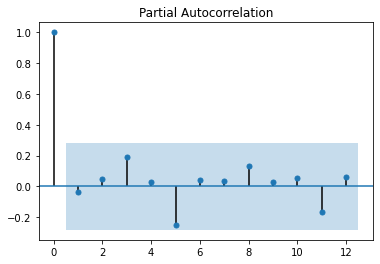

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(sales, lags =12)
plt.show()

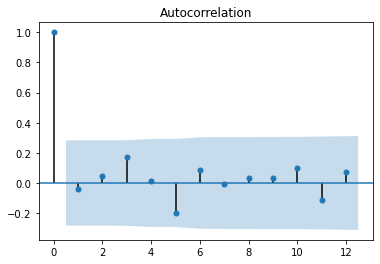

In [37]:
plot_acf(sales, lags =12)
plt.show()

### ACF and PACF plots to determine seasonal order P and Q values (Mean sales)

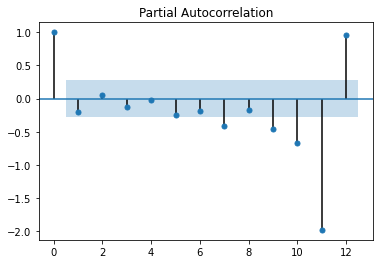

In [38]:
plot_pacf(decomposition.seasonal, lags =12)
plt.show()

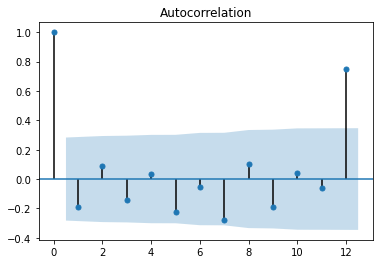

In [39]:
plot_acf(decomposition.seasonal, lags =12)
plt.show()

In [40]:
split = np.round(len(sales) * 0.75)
train = sales.iloc[:int(split)]
test = sales.iloc[int(split):]
print(len(train),len(test))

36 12


Since the data contains both Trend and Seasonality, We shall use SARIMA model

### SARIMA (Mean Sales)

In [41]:
# SARIMA model 
p=3; q=3; d=0
P = 1; Q = 1; D = 0
m1 = sm.tsa.statespace.SARIMAX(train,order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
print(m1.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Sales   No. Observations:                   36
Model:             SARIMAX(3, 0, 3)x(1, 0, [1], 12)   Log Likelihood                -217.208
Date:                              Mon, 09 May 2022   AIC                            452.415
Time:                                      10:21:00   BIC                            466.667
Sample:                                  01-01-2014   HQIC                           457.390
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2623      0.316      0.829      0.407      -0.358       0.883
ar.L2         -0.26

start = 36, end = 47
                actual   predicted         err
2017-01-01  248.501333  356.514751 -108.013418
2017-02-01  264.089900  356.913436  -92.823536
2017-03-01  286.669600  380.599627  -93.930027
2017-04-01  206.044502  325.625189 -119.580687
2017-05-01  319.953928  359.829902  -39.875974
2017-06-01  372.717386  382.637105   -9.919719
2017-07-01  227.173500  329.467734 -102.294234
2017-08-01  395.945487  353.203323   42.742164
2017-09-01  349.737422  395.490232  -45.752811
2017-10-01  308.226313  334.665846  -26.439534
2017-11-01  374.310253  347.845170   26.465083
2017-12-01  296.296857  397.666267 -101.369410


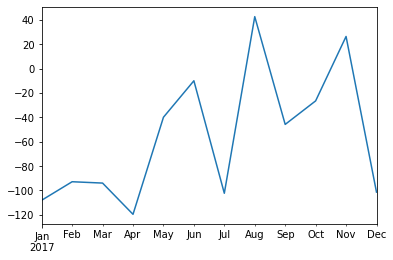

In [42]:
start = len(train)
end = len(train) + len(test) - 1



print('start = {}, end = {}'.format(start,end))

predictions = m1.predict(start=start,end=end,dynamic=True)

actual = []

for i in range(len(predictions)):
    actual.append(test[i])

df_res = pd.DataFrame({'actual':actual, 'predicted':predictions})
df_res['err'] = df_res.actual - df_res.predicted
print(df_res)
df_res.err.plot()
plt.show()

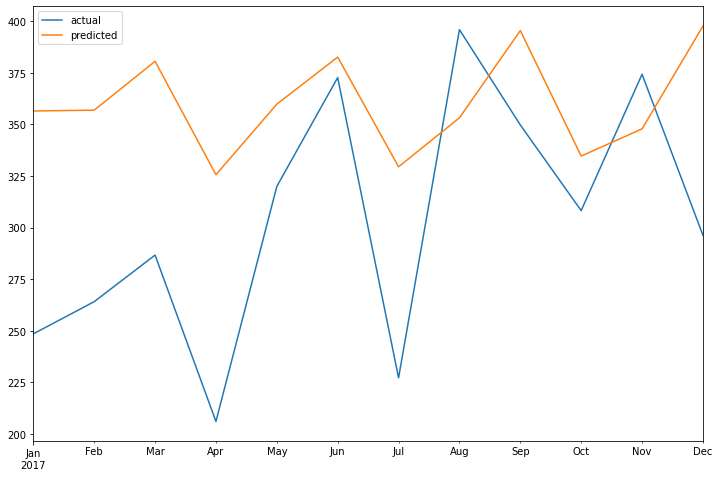

In [43]:
# plot
df_res[['actual','predicted']].plot(figsize=(12,8))

In [44]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m1.resid,lags=[1])[1][0]
print(pvalue)
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

0.8194557721727657
Fail-to-Reject H0. Good model


In [45]:
# MSE
mse1 = mean_squared_error(df_res.actual, df_res.predicted)
msg = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
print(msg + "\n\tMSE = {}\n\tRMSE = {}".format(mse1,np.sqrt(mse1)))

SARIMA Model. Order=(3,0,3)
	MSE = 5929.460130914176
	RMSE = 77.00298780511167


In [46]:
model = []
AIC = []
BIC = []
HQIC = []
RMSE = []

model.append('SARIMA - (3,0,3) seasonal_order=(1,0,1,12) (Mean Sales)')
AIC.append(m1.aic)
BIC.append(m1.bic)
HQIC.append(m1.hqic)
RMSE.append(np.sqrt(mse1))

2018-01-01    295.795535
2018-02-01    286.581571
2018-03-01    342.046186
2018-04-01    303.851031
2018-05-01    285.190160
2018-06-01    342.743832
2018-07-01    318.482346
2018-08-01    291.427505
2018-09-01    328.002242
2018-10-01    337.087831
2018-11-01    292.398661
2018-12-01    308.393735
2019-01-01    340.890465
Freq: MS, dtype: float64


Text(0.5, 1.0, 'SARIMA Model. Order=(3,0,3)')

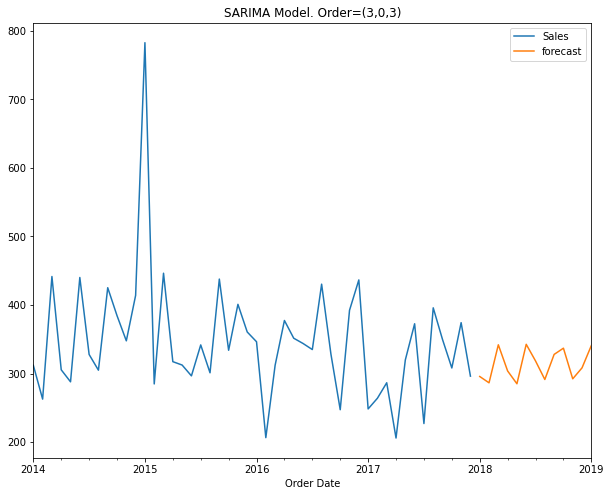

In [47]:
p = 3; d = 0; q = 3
P = 1; D = 0; Q = 1
m3_f = sm.tsa.statespace.SARIMAX(sales,order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
fcast = m3_f.predict(start=len(sales), end=len(sales)+12, typ='levels')
print(fcast)

sales.plot(figsize=(10,8),legend=True)
fcast.plot(legend=True,label = 'forecast')
plt.title(msg)

## SARIMAX (Mean Sales)

In [48]:
discount = data1['Discount'].resample('MS').mean()
quantity = data1['Quantity'].resample('MS').mean()

exog = pd.merge(discount,quantity, on = 'Order Date' )

In [49]:
# SARIMAX model
p=3; q=3; d=0
P = 1;Q = 1; D = 0
m2 = sm.tsa.statespace.SARIMAX(train,order=(p,d,q),seasonal_order=(P,D,Q,12),exog = exog.iloc[:int(split),:]).fit()
print(m2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Sales   No. Observations:                   36
Model:             SARIMAX(3, 0, 3)x(1, 0, [1], 12)   Log Likelihood                -208.186
Date:                              Mon, 09 May 2022   AIC                            438.372
Time:                                      10:21:02   BIC                            455.791
Sample:                                  01-01-2014   HQIC                           444.452
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Discount    1011.4258    981.145      1.031      0.303    -911.583    2934.435
Quantity      54.08

start = 36, end = 47
                actual   predicted         err
2017-01-01  248.501333  324.972718  -76.471385
2017-02-01  264.089900  384.127067 -120.037167
2017-03-01  286.669600  336.537666  -49.868066
2017-04-01  206.044502  392.727142 -186.682640
2017-05-01  319.953928  322.955822   -3.001893
2017-06-01  372.717386  367.504442    5.212945
2017-07-01  227.173500  325.837717  -98.664217
2017-08-01  395.945487  378.602587   17.342900
2017-09-01  349.737422  354.840027   -5.102605
2017-10-01  308.226313  390.219817  -81.993504
2017-11-01  374.310253  387.558168  -13.247915
2017-12-01  296.296857  354.354676  -58.057820


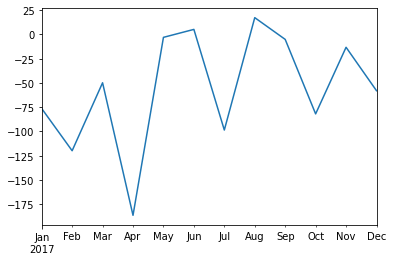

In [50]:
start = len(train)
end = len(train) + len(test) - 1

print('start = {}, end = {}'.format(start,end))

predictions = m2.predict(start=start,end=end,dynamic=True,exog = exog.iloc[int(split):,:])

df_res = pd.DataFrame({'actual':actual, 'predicted':predictions})
df_res['err'] = df_res.actual - df_res.predicted
print(df_res)
df_res.err.plot()
plt.show()

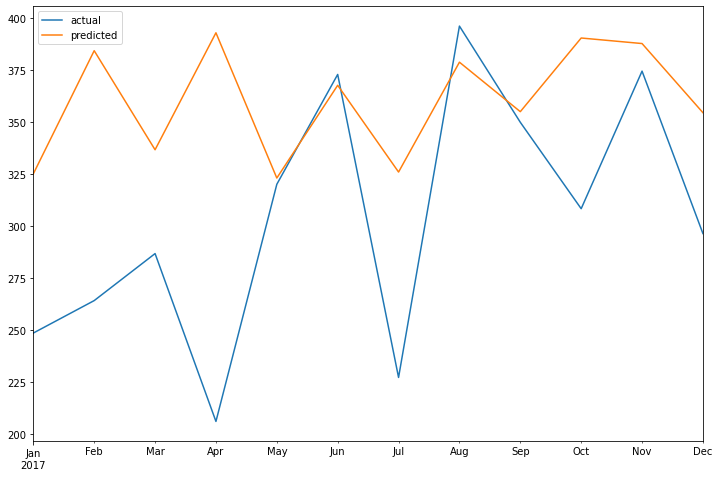

In [51]:
# plot
df_res[['actual','predicted']].plot(figsize=(12,8))
plt.show()

In [52]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m2.resid,lags=[1])[1][0]
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [53]:
# MSE
mse2 = mean_squared_error(df_res.actual, df_res.predicted)
msg = 'SARIMAX Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
print(msg + "\n\tMSE = {}\n\tRMSE = {}".format(mse2,np.sqrt(mse2)))

SARIMAX Model. Order=(3,0,3)
	MSE = 6496.733763341167
	RMSE = 80.60231859779945


2018-01-01    393.632557
2018-02-01    331.682605
2018-03-01    323.869334
2018-04-01    330.569406
2018-05-01    346.688086
2018-06-01    352.434788
2018-07-01    319.174295
2018-08-01    358.437851
2018-09-01    343.020710
2018-10-01    360.878242
2018-11-01    367.954814
2018-12-01    324.065899
Freq: MS, dtype: float64


Text(0.5, 1.0, 'SARIMAX Model. Order=(3,0,3)')

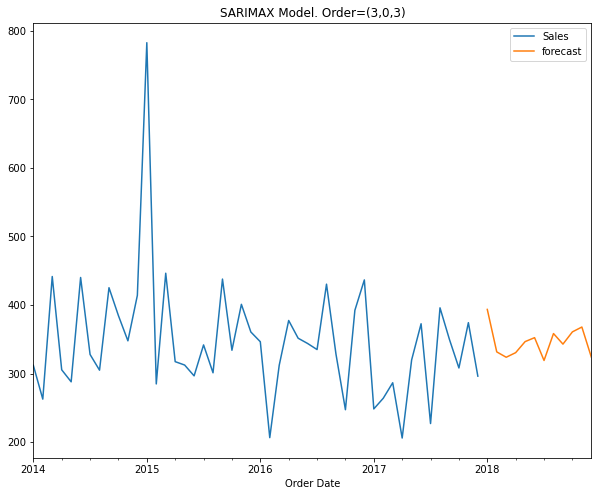

In [54]:
p=3; q=3; d=0
P = 1; Q = 1; D = 0
m2_f = sm.tsa.statespace.SARIMAX(sales,order=(p,d,q),seasonal_order=(P,D,Q,12),exog = exog).fit()
fcast = m2_f.forecast(12,exog=exog.iloc[int(split):,:])
print(fcast)

sales.plot(figsize=(10,8),legend=True)
fcast.plot(legend=True,label = 'forecast')
plt.title(msg)

In [55]:
model.append('SARIMAX - (3,0,3) seasonal_order=(1,0,1,12) (Mean Sales)')
AIC.append(m2.aic)
BIC.append(m2.bic)
HQIC.append(m2.hqic)
RMSE.append(np.sqrt(mse2))

# Total sales

In [56]:
sales1 = data1[data1['Category'] == 'Furniture']['Sales'].resample('MS').sum()

In [57]:
# Stationarity check
res = adfuller(sales1)
if res[1] < 0.05:
    print('data is stationary')
else:
    print('data is not stationary')
print(res[1])

data is stationary
8.450793985809671e-05


### ACF and PACF plots to determine p and q values (Total sales)

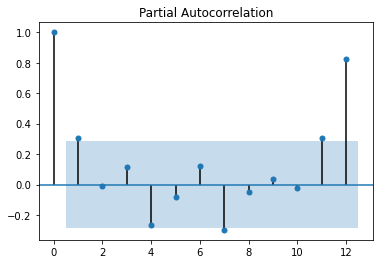

In [58]:
plot_pacf(sales1, lags = 12)
plt.show()

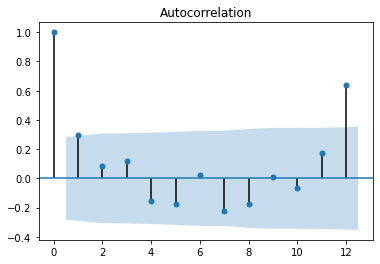

In [59]:
plot_acf(sales1, lags = 12)
plt.show()

In [60]:
decomposition1 = seasonal_decompose(sales1)

### ACF and PACF plots to determine seasonal order P and Q values (Total sales)

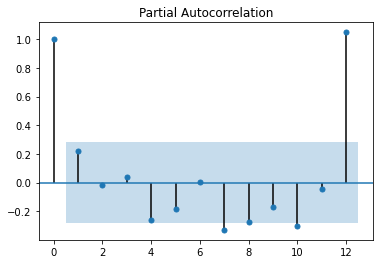

In [61]:
plot_pacf(decomposition1.seasonal, lags = 12)
plt.show()

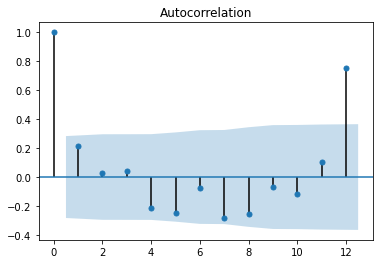

In [62]:
plot_acf(decomposition1.seasonal, lags = 12)
plt.show()

In [63]:
split = np.round(len(sales1) * 0.75)
train1 = sales.iloc[:int(split)]
test1 = sales.iloc[int(split):]
print(len(train1),len(test1))

36 12


## Sarima model (Total sales)

In [64]:
# SARIMA model 
p=1; q=1; d=0
P = 1; Q = 1; D = 0
m3 = sm.tsa.statespace.SARIMAX(train1,order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
print(m3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   36
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -217.769
Date:                            Mon, 09 May 2022   AIC                            445.539
Time:                                    10:21:05   BIC                            453.457
Sample:                                01-01-2014   HQIC                           448.302
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.016     64.457      0.000       0.969       1.030
ma.L1         -0.9813      0.582   

start = 36, end = 47
                actual   predicted         err
2017-01-01  248.501333  380.624648 -132.123315
2017-02-01  264.089900  340.121786  -76.031886
2017-03-01  286.669600  366.378654  -79.709054
2017-04-01  206.044502  354.652187 -148.607685
2017-05-01  319.953928  351.797089  -31.843160
2017-06-01  372.717386  359.340430   13.376956
2017-07-01  227.173500  354.882019 -127.708519
2017-08-01  395.945487  356.783033   39.162455
2017-09-01  349.737422  365.856548  -16.119126
2017-10-01  308.226313  352.541583  -44.315270
2017-11-01  374.310253  362.915081   11.395172
2017-12-01  296.296857  367.046589  -70.749732


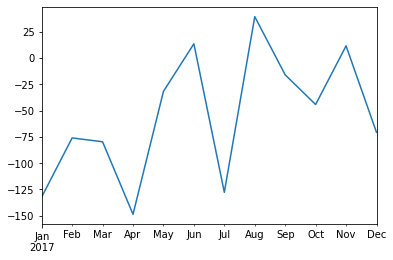

In [65]:
start = len(train1)
end = len(train1) + len(test1) - 1



print('start = {}, end = {}'.format(start,end))

predictions = m3.predict(start=start,end=end,dynamic=True)

actual = []

for i in range(len(predictions)):
    actual.append(test1[i])

df_res = pd.DataFrame({'actual':actual, 'predicted':predictions})
df_res['err'] = df_res.actual - df_res.predicted
print(df_res)
df_res.err.plot()
plt.show()

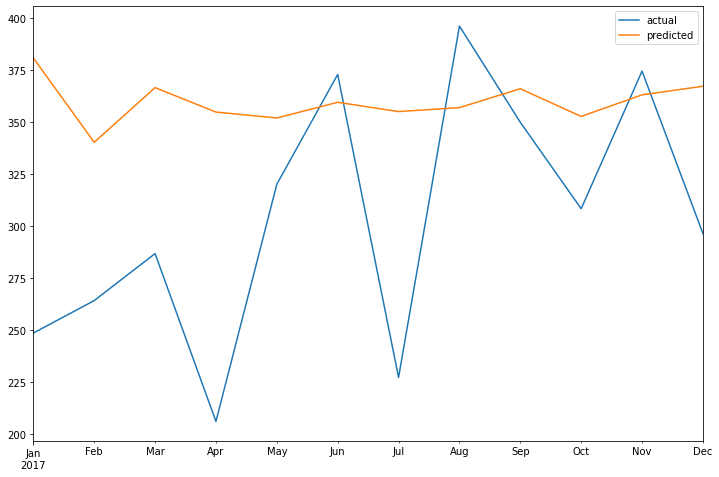

In [66]:
# plot
df_res[['actual','predicted']].plot(figsize=(12,8))

In [67]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m3.resid,lags=[1])[1][0]
print(pvalue)
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")


0.6805920107418287
Fail-to-Reject H0. Good model


In [68]:
# MSE
mse3 = mean_squared_error(df_res.actual, df_res.predicted)
msg = 'SARIMA Model. order=(' + str(p) + ',' + str(d) + ',' + str(q) + ') ' + 'seasonal order = (' + str(P) + ',' + str(D) + ',' + str(Q) + ',12)'
print(msg + "\n\tMSE = {}\n\tRMSE = {}".format(mse3,np.sqrt(mse3)))



SARIMA Model. order=(1,0,1) seasonal order = (1,0,1,12)
	MSE = 6505.861057558724
	RMSE = 80.6589180286887


2018-01-01     7296.008186
2018-02-01     6092.437842
2018-03-01    11747.376348
2018-04-01    10317.356096
2018-05-01    15246.861522
2018-06-01    16116.961755
2018-07-01    12294.564102
2018-08-01    13811.755472
2018-09-01    27174.266147
2018-10-01    17877.586399
2018-11-01    33200.826894
2018-12-01    30660.459301
2019-01-01     7524.698380
Freq: MS, dtype: float64


Text(0.5, 1.0, 'SARIMA Model. order=(1,0,1) seasonal order = (1,0,1,12)')

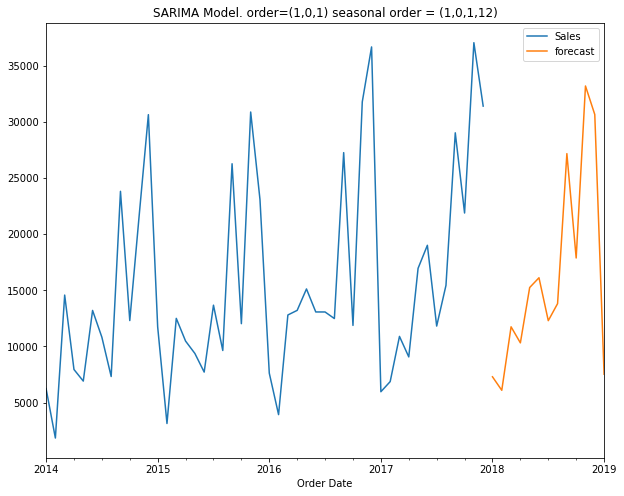

In [69]:
p = 1; d = 0; q = 1
P = 1; D = 0; Q = 1
m3_f = sm.tsa.statespace.SARIMAX(sales1,order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
fcast = m3_f.predict(start=len(sales1), end=len(sales1)+12, typ='levels')
print(fcast)

sales1.plot(figsize=(10,8),legend=True)
fcast.plot(legend=True,label = 'forecast')
plt.title(msg)

In [70]:
model.append('SARIMA - (1,0,1) seasonal_order=(1,0,1,12) (Total Sales)')
AIC.append(m3.aic)
BIC.append(m3.bic)
HQIC.append(m3.hqic)
RMSE.append(np.sqrt(mse3))

## SARIMAX Model (Total Sales)

In [71]:
discount1 = data1['Discount'].resample('MS').sum()
quantity1 = data1['Quantity'].resample('MS').sum()

exog1 = pd.merge(discount1,quantity1, on = 'Order Date' )

In [72]:
# SARIMAX model
p=1; q=1; d=0
P = 1;Q = 1; D = 0
m4 = sm.tsa.statespace.SARIMAX(train1,order=(p,d,q),seasonal_order=(P,D,Q,12),exog = exog1.iloc[:int(split),:]).fit()
print(m4.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   36
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -223.983
Date:                            Mon, 09 May 2022   AIC                            461.966
Time:                                    10:21:06   BIC                            473.051
Sample:                                01-01-2014   HQIC                           465.835
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Discount      -2.4418     18.949     -0.129      0.897     -39.581      34.697
Quantity       0.1449      0.827   

start = 36, end = 47
                actual   predicted         err
2017-01-01  248.501333  350.503507 -102.002174
2017-02-01  264.089900  327.390000  -63.300100
2017-03-01  286.669600  376.199536  -89.529936
2017-04-01  206.044502  332.929765 -126.885263
2017-05-01  319.953928  361.358755  -41.404826
2017-06-01  372.717386  355.414908   17.302479
2017-07-01  227.173500  367.451722 -140.278222
2017-08-01  395.945487  374.728936   21.216551
2017-09-01  349.737422  398.722264  -48.984842
2017-10-01  308.226313  360.096800  -51.870487
2017-11-01  374.310253  409.201239  -34.890986
2017-12-01  296.296857  407.537400 -111.240544


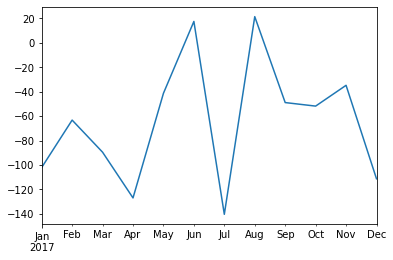

In [73]:
start = len(train1)
end = len(train1) + len(test1) - 1

print('start = {}, end = {}'.format(start,end))

predictions = m4.predict(start=start,end=end,dynamic=True,exog = exog1.iloc[int(split):,:])

df_res = pd.DataFrame({'actual':actual, 'predicted':predictions})
df_res['err'] = df_res.actual - df_res.predicted
print(df_res)
df_res.err.plot()
plt.show()

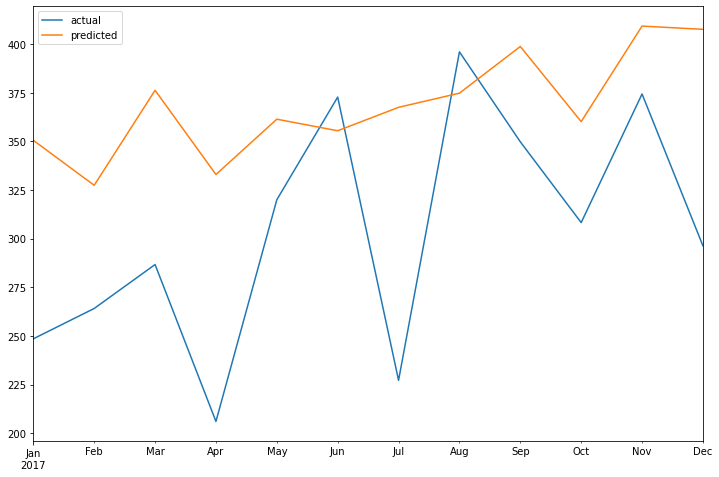

In [74]:
# plot
df_res[['actual','predicted']].plot(figsize=(12,8))
plt.show()

In [75]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m4.resid,lags=[1])[1][0]
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [76]:
# MSE
mse4 = mean_squared_error(df_res.actual, df_res.predicted)
msg = 'SARIMAX Model. order=(' + str(p) + ',' + str(d) + ',' + str(q) + ') ' + 'seasonal order = (' + str(P) + ',' + str(D) + ',' + str(Q) + ',12)'
print(msg + "\n\tMSE = {}\n\tRMSE = {}".format(mse4,np.sqrt(mse4)))

SARIMAX Model. order=(1,0,1) seasonal order = (1,0,1,12)
	MSE = 6612.548671738773
	RMSE = 81.31757910648086


2018-01-01    11156.757033
2018-02-01     7432.827906
2018-03-01    16343.513814
2018-04-01    14487.950897
2018-05-01    17465.110211
2018-06-01    18724.237151
2018-07-01    15808.278437
2018-08-01    16859.777542
2018-09-01    32327.102980
2018-10-01    22670.539873
2018-11-01    36366.856060
2018-12-01    33610.208871
Freq: MS, dtype: float64


Text(0.5, 1.0, 'SARIMAX Model. order=(1,0,1) seasonal order = (1,0,1,12)')

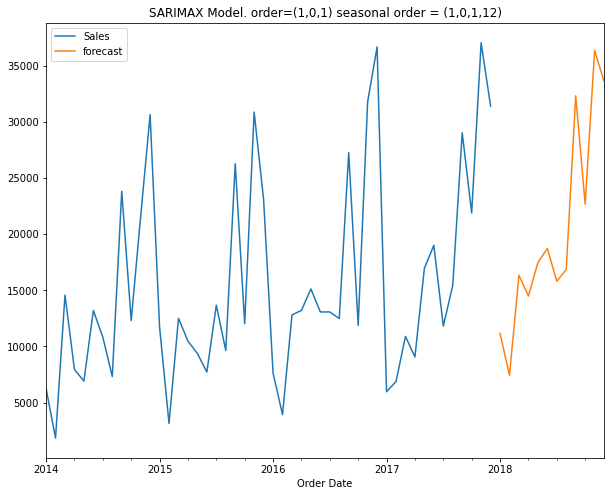

In [77]:
p=1; q=1; d=0
P = 1; Q = 1; D = 0
m4_f = sm.tsa.statespace.SARIMAX(sales1,order=(p,d,q),seasonal_order=(P,D,Q,12),exog = exog1).fit()
fcast = m4_f.forecast(12,exog=exog1.iloc[int(split):,:])
print(fcast)

sales1.plot(figsize=(10,8),legend=True)
fcast.plot(legend=True,label = 'forecast')
plt.title(msg)

In [78]:
model.append('SARIMAX - (1,0,1) seasonal_order=(1,0,1,12) (Total Sales)')
AIC.append(m4.aic)
BIC.append(m4.bic)
HQIC.append(m4.hqic)
RMSE.append(np.sqrt(mse4))

In [79]:
pd.set_option('max_colwidth', 400)
results = pd.DataFrame({'model':model, 'AIC': AIC, 'BIC' : BIC, 'HQIC' : HQIC, 'RMSE' : RMSE})
results

,model,AIC,BIC,HQIC,RMSE
0,"SARIMA - (3,0,3) seasonal_order=(1,0,1,12) (Mean Sales)",452.415373,466.667044,457.389588,77.002988
1,"SARIMAX - (3,0,3) seasonal_order=(1,0,1,12) (Mean Sales)",438.372112,455.790820,444.451707,80.602319
2,"SARIMA - (1,0,1) seasonal_order=(1,0,1,12) (Total Sales)",445.538975,453.456570,448.302428,80.658918
3,"SARIMAX - (1,0,1) seasonal_order=(1,0,1,12) (Total Sales)",461.966424,473.051056,465.835257,81.317579
